# Pronóstico de erupciones volcánicas
- Alvarado Morán Óscar
- Bermúdez Marbán Dante

# Índice
1. [Análisis exploratorio de datos](#Análisis-exploratorio-de-datos)
2. [Visualización](#Análisis-Visual-de-los-Datos)
3. [Imputación](#Imputando-datos)
4. [Análisis de señales](#Análisis-de-señales)
5. [Modelo (LGBM)](#Implementando-LGBM)
6. [Resultados](#Resultados)

In [1]:
from threading import Thread      # For parallelism
import numpy as np                # For numeric operations
import pandas as pd               # For data analysis
from os import listdir, path      # For system manage
import matplotlib.pyplot as plt   # To use seaborn more specific.
import seaborn as sns             # To visualizate some plots.

#!conda install -c conda-forge librosa -y
import librosa                    # Wave analysis

# For an interactive visualization
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#!conda install -c conda-forge lightgbm -y
import lightgbm as lgb            # For LGBM model

# To split datasets and get the mean absolute error.
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# To obtain some signal characteristics
from scipy.signal import find_peaks, peak_prominences, periodogram, peak_widths

from scipy.interpolate import UnivariateSpline

import statsmodels as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa import stattools

from time import time
from datetime import timedelta

## Análisis exploratorio de datos

Los datos se encuentran en [Kaggle](https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/data). En el desafío de finales de 2020 "_INGV - Volcanic Eruption Prediction_".

In [2]:
# Exploring a dataset from the 4,431 files of training.
train_dir = "/home/oscar/Documentos/LCD/Volcanes/predict-volcanic-eruptions-ingv-oe/train" # Oscar
train_filenames = listdir(train_dir)
# Just a file
train_filename = train_filenames[0]
print(train_filename)
data = pd.read_csv(path.join(train_dir,train_filename), dtype="Int16")
data.head()

1083379708.csv


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,-122,<NA>,21,224,-19,130,-32,<NA>,-53,434
1,-118,<NA>,-13,131,-80,167,-41,<NA>,-54,712
2,-113,<NA>,-49,8,-165,138,-35,<NA>,-53,911
3,-101,<NA>,-90,-116,-271,84,-38,<NA>,-37,1022
4,-84,<NA>,-129,-245,-382,113,-49,<NA>,-31,1064


Mostramos algunas estadísticas importantes de un archivo de todo el conjunto de datos.

In [3]:
data.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,60001.000000,0,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,0,60001.000000,60001.000000
mean,0.797320,<NA>,0.190997,-3.525641,-0.757687,-4.323245,1.383010,<NA>,0.508075,-0.474809
std,312.750805,<NA>,269.668139,329.800720,221.876101,200.083887,254.389676,<NA>,330.120142,666.593175
min,-1970.000000,<NA>,-2293.000000,-2435.000000,-2252.000000,-791.000000,-1385.000000,<NA>,-1813.000000,-4151.000000
25%,-181.000000,<NA>,-146.000000,-186.000000,-130.000000,-133.000000,-146.000000,<NA>,-187.000000,-403.000000
50%,0.000000,<NA>,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,0.000000,0.000000
75%,181.000000,<NA>,144.000000,176.000000,130.000000,126.000000,151.000000,<NA>,184.000000,406.000000
max,2023.000000,<NA>,1971.000000,3124.000000,1741.000000,892.000000,1542.000000,<NA>,2267.000000,4049.000000


## Etiquetas de los datos

In [4]:
# File with the name of all the other files and its label, in this case is the time to eruption.

target_path = "../csvs/train.csv"
target_csv = pd.read_csv(target_path)
target_csv.head()

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


Mostramos las mismas estadísticas para el noombre de los archivos y las etiquetas.

In [5]:
# Some important statistical characteristics of the last file. 
target_csv.describe()

,segment_id,time_to_eruption
count,4.431000e+03,4.431000e+03
mean,1.074694e+09,2.284891e+07
std,6.161966e+08,1.348439e+07
min,5.131810e+05,6.250000e+03
25%,5.527934e+08,1.127016e+07
50%,1.066153e+09,2.246559e+07
75%,1.606350e+09,3.434356e+07
max,2.146939e+09,4.904609e+07


Mostramos a continuación la distribución de los datos del _tiempo para la erupción_.

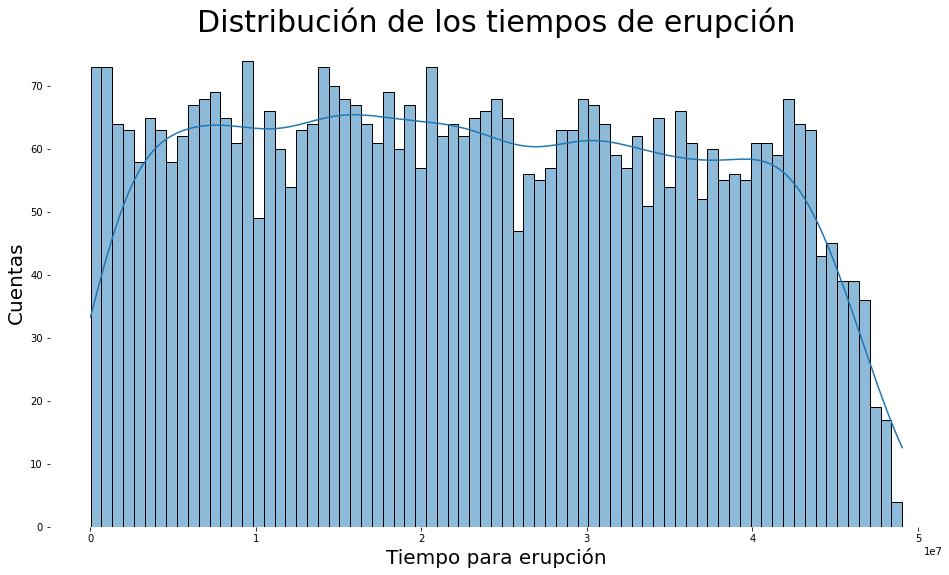

In [6]:
fig, ax = plt.subplots(figsize=(16,9))
sns.histplot(data=target_csv, x="time_to_eruption", bins=75, kde=True)
[ax.spines[i].set_visible(False) for i in ax.spines.keys() if i != "buttom"]; # To delete the spines
ax.set_xlabel("Tiempo para erupción", fontsize = 20)
ax.set_ylabel("Cuentas", fontsize = 20)
ax.set_title("Distribución de los tiempos de erupción", fontsize = 30)
fig.savefig("../imgs/Distribucion.png", bbox_inches="tight")

Se podría pensar que pareciera uniforme excepto por el límite superior (hasta la derecha) que desciende abruptamente. Significa que hay menos archivos con tiempos de erupción pequeños. 

A continuación vemos los datos faltantes y si hay señales que sean constantes (que se hace la suposición de que son un error).

In [5]:
def check_prank(data):
    """
    Function to check the number on NaNs in the file's columns or if the column is a constant.
    
    Parameters
        data: pd.Dataframe 
        Dataframe to analyse.
        
    Returns
        only_nans: list 
        List of integers with the NaNs by column.
        
        only_constants: list 
        Boolean list saying if the column is a constant or not. 
    """
    nrows, _ = data.shape
    only_nans = [data[sensor].isna().sum() for sensor in data.columns]
    only_constants = [data[sensor].std() == 0 for sensor in data.columns]
    
    return only_nans, only_constants

In [6]:
def yield_partition(data, npartitions):
    """
    Generator to do the partition over the data in the number of npartitions that could be possible.
    
    Parameters
        data: np.array 
        Numpy array to be partitionated.
        
        npartitions: int 
        Int of threads to be used.
        
    yields
        slice of data
    """
    n_elements = len(data)
    n = n_elements//npartitions
    
    for k in range(npartitions):
        i = k*n
        j = (k+1)*n
        if k != npartitions - 1:
            yield data[i:j]
        else:
            yield data[i:]  # Last one

In [7]:
def parallelize(nthreads):
    """
    Decorator to parallelise operations over data
    
    Parameters
        nthreads: int 
        Number of threads to be used.
        
    Returns
        decorator
    """
    def decorator(original_function):
        def parallelized_function(dir_path, filenames, verbose=True):
            parallel_ans = []
            threads = []
            counter = 1
    
            # Separate the data
            for partition in yield_partition(filenames, nthreads):
                thread = Thread(target=original_function, args=(dir_path, partition, verbose, parallel_ans))
                threads.append(thread)
                print("Starting",counter)
                thread.start()
                counter += 1 
            
            for thread in threads:
                thread.join()
            
            list_nans = [df_nan for df_nan, df_constant in parallel_ans]
            list_constants = [df_constant for df_nan, df_constant in parallel_ans]
            concatenation_nans = pd.concat(list_nans)
            concatenation_constants = pd.concat(list_constants)
            return concatenation_nans, concatenation_constants
        
        return parallelized_function
    
    return decorator

In [8]:
@parallelize(8)
def check_pranks(dir_path, filenames, verbose=True, parallel_ans = None):
    """
    Function to check the number of NaNs in a column or if all the column are a constant.
    
    Parameters
        dir_path: string 
        Path in system where we have the training files.
        
        filenames: list
        List of training filenames.
        
    Returns
        df_nans: pd.Dataframe 
        Dataframe with the NaNs by columns of all the files.
        
        df_constants: pd.Dataframe 
        Dataframe with True or False saying if the columns is or not a constant.
    """
    nans = []
    constants = []
    for i,filename in enumerate(filenames,1):
        df = pd.read_csv(path.join(dir_path,filename), dtype="Int16")
        only_nans, only_constants = check_prank(df)
        nans.append(only_nans)
        constants.append(only_constants)
        if verbose and i%10 == 0:
            print(i)
    
    df_nans = pd.DataFrame(nans, columns=df.columns)
    df_constants = pd.DataFrame(constants, columns=df.columns)
    
    if parallel_ans != None:
        parallel_ans.append( (df_nans, df_constants) )
    else:
        return df_nans, df_constants

- Datos de entrenamiento

In [9]:
# Cheking the NaNs file after creating it using training data.
df_train_nans = pd.read_csv("../csvs/df_train_nans.csv")
df_train_nans.sum(axis=0)

sensor_1      1545802
sensor_2     50569629
sensor_3     26499171
sensor_4         6210
sensor_5     49241506
sensor_6        88904
sensor_7      2546627
sensor_8     26465572
sensor_9     10520113
sensor_10     1895973
dtype: int64

In [10]:
# Cheking the Constants file after creating it using training data.. 
df_train_constants = pd.read_csv("../csvs/df_train_constants.csv")
df_train_constants.sum(axis=0)

sensor_1     0
sensor_2     0
sensor_3     0
sensor_4     0
sensor_5     0
sensor_6     0
sensor_7     0
sensor_8     0
sensor_9     0
sensor_10    0
dtype: int64

- Datos de prueba

In [11]:
# Cheking the NaNs file after creating it using testing data.
df_test_nans = pd.read_csv("../csvs/df_test_nans.csv")
df_test_nans.sum(axis=0)

sensor_1     23328531
sensor_2     75807628
sensor_3     26593834
sensor_4        13406
sensor_5     92651510
sensor_6        57658
sensor_7      2713162
sensor_8     17653700
sensor_9     51208744
sensor_10    46050548
dtype: int64

In [12]:
# Cheking the Constants file after creating it using testing data.. 
df_test_constants = pd.read_csv("../csvs/df_test_constants.csv")
df_test_constants.sum(axis=0)

sensor_1       0
sensor_2       0
sensor_3       0
sensor_4       0
sensor_5       0
sensor_6       0
sensor_7       0
sensor_8       0
sensor_9       0
sensor_10    815
dtype: int64

### Estandarizando datos
Esto nos ayudará a centrar los datos.

In [9]:
# To standardize the data
def standardize(df):
    """
    Function to standardize the signals.
    
    Parameters
        df: pd.Dataframe 
        Dataframe to standardize by column.
        
    Returns
        standardize_df: pd.Dataframe 
        Dataframe standardized.
    """
    aggs = df.agg([np.nanmean, np.nanstd]).astype("float16")
    standardized_df = (df - aggs.loc["nanmean",:])/ aggs.loc["nanstd",:]
    return standardized_df

In [ ]:
# We don't have to re-run this code, we already did it. 
path_originals = "/home/oscar/Escritorio/predict-volcanic-eruptions-ingv-oe"
path_copies = "/home/oscar/Escritorio/estandarizados"
for directory in ["train", "test"]:
    paths = path.join(path_originals, directory)
    print(f"Comienzo con {directory}")
    for file in listdir(paths):
        reading = path.join(paths, file)
        writing = path.join(path_copies, directory, file)
        df = pd.read_csv(reading)
        s_df = standardize(df).astype("Float16")
        s_df.to_csv(writing, index = False)

## Exploración del sensado

Vemos cuántos datos hay en el conjunto de entrenamiento.

In [4]:
# How many training files do we have
train_dir = "../train"
train_filenames = listdir(train_dir)
len(train_filenames)

4432

In [16]:
# To get stats per file.
def get_stats_per_df(df):
    """
    Function to get some aggregation functions of each files.
    
    Parameters
        df: pd.Dataframe
        Dataframe to analyse and get the aggregation functions.
        
    Returns
        aggs: list 
        List of the auggmentation functions' results.
    """
    aggs = df.agg(["count", np.nanmean, np.nanstd, np.nanmin, np.nanmax])
    aggs = aggs.stack()
    aggs.index = aggs.index.map(lambda t:f"{t[1]}_{t[0]}")
    return aggs

In [ ]:
# Do not run again
%%time
stats_per_file = []
for i,filename in enumerate(train_filenames,1):
    df = pd.read_csv(os.path.join(train_dir_path, filename), dtype="Int16")
    temporal_stats = get_stats_per_df(df)
    stats_per_file.append(temporal_stats)
    if i%50 == 0:
        print(i)

Vemos algunas estadísticas por archivo `.csv`

In [17]:
# Reading the data that we wrote.
df_stats_per_file = pd.read_csv("../csvs/stats_per_file2.csv")
df_stats_per_file.head()

,segment_id,sensor_1_count,sensor_2_count,sensor_3_count,sensor_4_count,sensor_5_count,sensor_6_count,sensor_7_count,sensor_8_count,sensor_9_count,...,sensor_9_nanmax,sensor_10_nanmax,sensor_8_nanmean,sensor_8_nanstd,sensor_8_nanmin,sensor_8_nanmax,sensor_2_nanmean,sensor_2_nanstd,sensor_2_nanmin,sensor_2_nanmax
0,1136037770,60001.0,0.0,60001.0,60001.0,60001.0,60001.0,60001.0,0.0,60001.0,...,3884.0,4912.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1969647810,60001.0,0.0,60001.0,60001.0,2072.0,60001.0,0.0,60001.0,55407.0,...,1373.0,4026.0,2.562674,759.108629,-4284.0,6339.0,NaN,NaN,NaN,NaN
2,1895879680,60001.0,0.0,60001.0,60001.0,60001.0,60001.0,60001.0,0.0,60001.0,...,2182.0,4374.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2068207140,60001.0,0.0,60001.0,60001.0,60001.0,60001.0,60001.0,0.0,60001.0,...,2605.0,3692.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192955606,60001.0,60001.0,60001.0,60001.0,60001.0,60001.0,60001.0,60001.0,60001.0,...,1246.0,2288.0,0.743654,157.809455,-731.0,740.0,-1.041783,394.16549,-5766.0,5967.0


In [18]:
def get_stats_vec(data):
    """
    Function to apply functions saved in a list, is faster. We apply this functions: counts, sum, sum²(), min,
    max.
    
    Parameters
        data: np.array 
        The signal of one sensor.
    
    Returns
        vec: np.array
        Array that contains the stats.
    """
    data_notnans = data[~np.isnan(data)]
    stats = [len, np.sum, lambda x:np.sum(x**2),
             lambda x:np.min(x) if len(x) else np.inf,
             lambda x:np.max(x) if len(x) else -np.inf]
    vec = [stat(data_notnans) for stat in stats]
    vec = np.array(vec)
    return vec

In [19]:
def get_stats_vecs(df):
    """
    Function to get stats by vector per file.
    
    Parameters
        df: pd.Dataframe
        Dataframe to be used to get stats by sensor (column).
    Returns
        matrix: np.matrix 
        Matrix that contains stats per file per column.
    """
    vecs = [get_stats_vec(df[column]) for column in df.columns]
    matrix = np.vstack(vecs)
    return matrix

In [ ]:
# Do not run again, already runed.
# To get stats by all the files joined, we obtain the max of maxs, the min of mins.
%%time
stats = np.zeros(shape=(10,5))
stats[:,3] = np.inf
stats[:,4] = -np.inf
for filenames in train_filenames:
    df = pd.read_csv( os.path.join(train_dir_path, filename) )
    current_stats = get_stats_vecs(df)
    stats[:,:3] += current_stats[:,:3]
    stats[:,3] = np.minimum(stats[:,3], current_stats[:,3])
    stats[:,4] = np.maximum(stats[:,4], current_stats[:,4])

In [20]:
def get_stats_df(matrix):
    """
    Function to get a dataframe with the stats merging all the files.
    
    Parameters
        matrix: np.matrix 
        Matrix with the stats merged.
        
    Returns
        stats_df: pd.Dataframe
        Dataframe with the final stats merging all the data.
    """
    sensors = [f"sensor_{i+1}" for i in range(10)]
    stats_names = ["count", "mean", "std", "min", "max"]
    
    nrows, ncols = matrix.shape
    
    stats_vecs = []
    for row in range(nrows): # for every sensor
        count = matrix[row,0]
        total_sum = matrix[row,1]
        mean = total_sum/count
        total_squared_sum = matrix[row,2]
        std = np.sqrt( (total_squared_sum - count*mean**2)/(count-1) )
        minimum = matrix[row,3]
        maximum = matrix[row,4]
        stats = [count, mean, std, minimum, maximum]
        stats_vecs.append(np.array(stats))
        
    new_matrix = np.vstack(stats_vecs)
    
    stats_df = pd.DataFrame(new_matrix, columns=stats_names, index=sensors)
    
    return stats_df

In [ ]:
# We already did this, do not run again.
whole_stats = get_stats_df(stats)
whole_stats

Ahora vienen los datos generales para cada sensor, se toman en cuenta TODOS los archivos `.csv`

In [21]:
# Reading the whole stats file.
whole_stats = pd.read_csv("../csvs/whole_stats.csv")
whole_stats

,Unnamed: 0,count,mean,std,min,max
0,sensor_1,265864431.0,0.025250,203.303099,-1171.0,1278.0
1,sensor_2,265864431.0,-0.431776,418.222197,-4759.0,4118.0
2,sensor_3,265864431.0,0.233829,178.179004,-1288.0,1212.0
3,sensor_4,265864431.0,0.281562,200.602547,-1280.0,1532.0
4,sensor_5,265864431.0,-0.000650,161.583577,-1225.0,1370.0
5,sensor_6,265864431.0,0.044916,299.005016,-3226.0,2575.0
6,sensor_7,265864431.0,4.590190,204.956910,-986.0,983.0
7,sensor_8,265864431.0,-2.975500,247.542130,-934.0,1060.0
8,sensor_9,265864431.0,2.170547,196.562165,-1210.0,1316.0
9,sensor_10,265864431.0,-120.953801,937.478541,-3743.0,3229.0


[Regresar al índice](#Índice)

# Análisis Visual de los Datos

Haremos una visualización de los datos para entenderlos un poco mejor.

In [16]:
path_files = "/home/oscar/Documentos/LCD/Volcanes/predict-volcanic-eruptions-ingv-oe/"
train_dir = path.join(path_files, "train")
train_filenames = listdir(train_dir)
sample = pd.read_csv(path.join(train_dir, train_filenames[2]), dtype = "Int16")
sample.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,-65,259,127,235,-151,112,-120,-199,-183,-303
1,-99,218,152,230,-101,62,-81,-157,-157,-332
2,-92,191,140,199,-2,62,48,-186,-126,-344
3,-51,191,211,190,113,131,120,149,-121,-328
4,16,191,143,165,200,179,23,-103,-117,-253


In [19]:
def plot_amp_ply(df):
    """Graph sensor data
    Parameters:
        df: pd.DataFrame
        Dataframe with 10 columns, corresponding to data from sensors
    """
    valids = ~df.isna().all()
    valids = list(valids[valids].index)
    fig = make_subplots(rows = len(valids), cols=1, y_title = "Amplitudes", x_title = "Tiempo [cs]")
    for idx, sensor in enumerate(valids):
        data = df.loc[:, sensor]
        fig.append_trace(go.Scatter(x = list(range(df.shape[0])), y = data, 
                                    mode = "lines", name = f"{sensor}"), 
                                     row = idx+1, col = 1)

    fig.update_layout(height = 1000, width = 950, title_text = "Diagramas de amplitudes", title_font_size = 30)
    fig.show()

In [ ]:
# Plotting a random sample
#plot_amp_ply(sample)

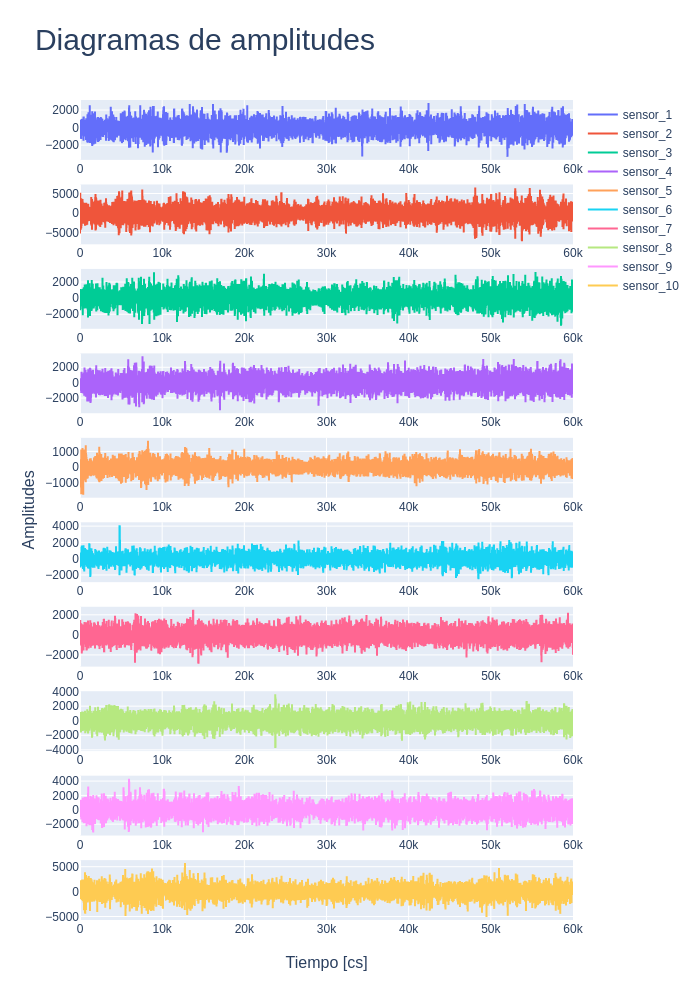

In [21]:
# Showing the real values
sample.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,-65,259,127,235,-151,112,-120,-199,-183,-303
1,-99,218,152,230,-101,62,-81,-157,-157,-332
2,-92,191,140,199,-2,62,48,-186,-126,-344
3,-51,191,211,190,113,131,120,149,-121,-328
4,16,191,143,165,200,179,23,-103,-117,-253


In [24]:
# We read the labels' file
path_files = "../csvs"
train_path = path.join(path_files, "train.csv")
train_data = pd.read_csv(train_path)
train_data

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429
...,...,...
4426,873340274,15695097
4427,1297437712,35659379
4428,694853998,31206935
4429,1886987043,9598270


Veremos si en el conjunto de datos hay alguno que tenga el mismo tiempo de erupción.

In [25]:
# Checking if we have duplicates
train_data[train_data.time_to_eruption.duplicated()]

,segment_id,time_to_eruption
1777,1049892705,23385989


In [27]:
# Duplicate #1
same1 = pd.read_csv(path.join(train_dir, "549832738.csv"))
plot_amp_ply(same1)

In [ ]:
# Duplicate #2
same2 = pd.read_csv(path.join(train_dir, "1049892705.csv"))
plot_amp_ply(same2)

Ordenamos por tiempos más próximos a erupción

In [28]:
# Sort labels' data by time to eruption.
sorted_data = train_data.iloc[train_data.time_to_eruption.sort_values().index]
sorted_data.index = range(len(sorted_data))
sorted_data

,segment_id,time_to_eruption
0,601524801,6250
1,1658693785,25730
2,1957235969,26929
3,442994108,28696
4,1626437563,40492
...,...,...
4426,1162128945,48387290
4427,1131527270,48522449
4428,356854390,48727004
4429,1552761888,48814294


[Regresar al índice](#Índice)

# Imputando datos

In [7]:
whole_stats = pd.read_csv("../csvs/whole_stats.csv", index_col=0)
#whole_stats.rename(lambda n:f"sensor_{n+1}", inplace=True)
whole_stats

,count,mean,std,min,max
sensor_1,265864431.0,0.025250,203.303099,-1171.0,1278.0
sensor_2,265864431.0,-0.431776,418.222197,-4759.0,4118.0
sensor_3,265864431.0,0.233829,178.179004,-1288.0,1212.0
sensor_4,265864431.0,0.281562,200.602547,-1280.0,1532.0
sensor_5,265864431.0,-0.000650,161.583577,-1225.0,1370.0
sensor_6,265864431.0,0.044916,299.005016,-3226.0,2575.0
sensor_7,265864431.0,4.590190,204.956910,-986.0,983.0
sensor_8,265864431.0,-2.975500,247.542130,-934.0,1060.0
sensor_9,265864431.0,2.170547,196.562165,-1210.0,1316.0
sensor_10,265864431.0,-120.953801,937.478541,-3743.0,3229.0


### Análisis de series de tiempo

#### Tendencia

En este caso es cero, porque la media no cambia con el tiempo (o sea no va subiendo y/o bajando)

#### Periodicidad

Se puede encontrar con una gráfica de autocorrelación. Consiste en calcular la correlación respecto los datos y estos mismo pero desplazados una cierta cantidad de unidades en el tiempo. Correlaciones altas indican posibles periodos

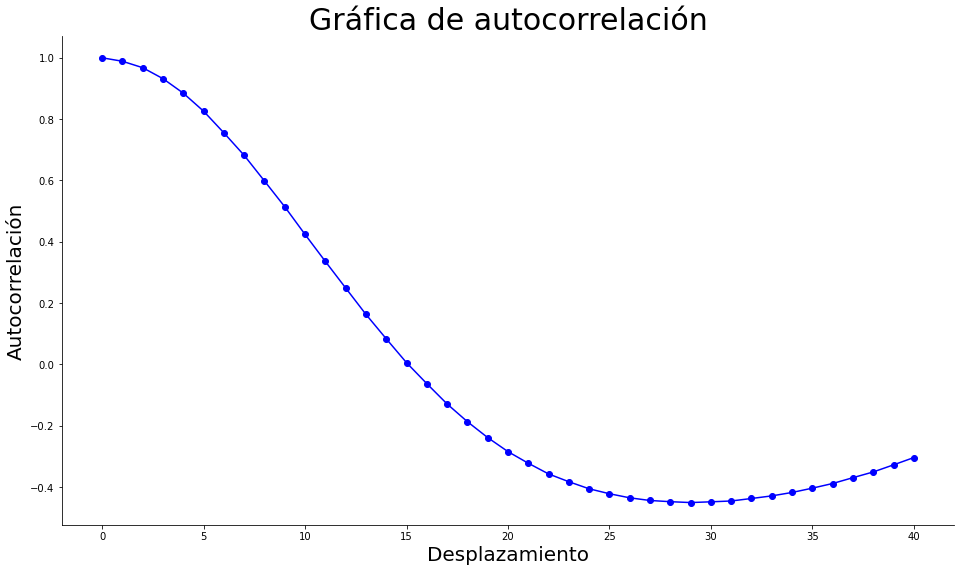

In [8]:
path_sample = "/home/oscar/Documentos/LCD/Volcanes/predict-volcanic-eruptions-ingv-oe/train"
filename_sample = listdir(path_sample)[3]
sample = pd.read_csv(path.join(path_sample, filename_sample))
autocorrelation = stattools.acf(sample.sensor_1, nlags=40, fft=False)

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(autocorrelation, "bo-")
#ax.scatter(np.arange(0,41), autocorrelation)

ax.set_title("Gráfica de autocorrelación", fontsize = 30)
ax.set_ylabel("Autocorrelación", fontsize = 20)
ax.set_xlabel("Desplazamiento", fontsize = 20)
[ax.spines[i].set_visible(False) for i in ax.spines if i not in ["bottom", "left"]]; # To delete the spines
fig.savefig("../imgs/Autocorrelación.png", bbox_inches="tight")

In [9]:
higher_correlation = np.sort(autocorrelation)[-2]
np.argwhere(autocorrelation == higher_correlation).squeeze()

array(1)

In [10]:
serie1 = sample.sensor_1
train, test = serie1.iloc[:40000], serie1.iloc[40000:]

In [11]:
holtwinters = ExponentialSmoothing(train, trend=None, seasonal="add", seasonal_periods=2, 
                                   initialization_method="estimated").fit(optimized=True)

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [12]:
pred = holtwinters.predict(start=test.index[0], end=test.index[-1])

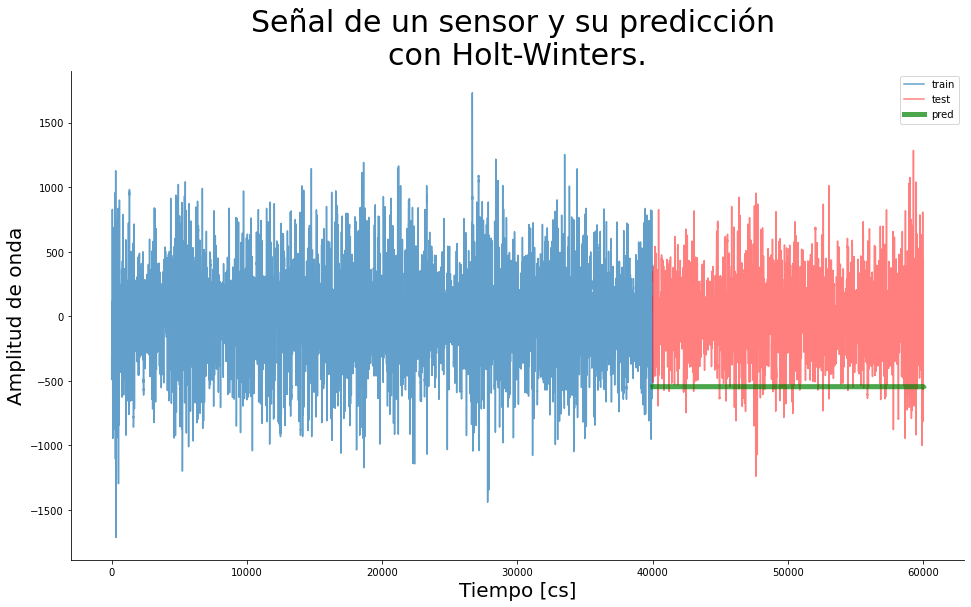

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(train.index,train, label="train", alpha = 0.7)
ax.plot(test.index,test,label="test", c = "r", alpha = 0.5)
ax.plot(pred, label="pred", c = "g", lw = 5, alpha = 0.7)
ax.set_xlabel("Tiempo [cs]", fontsize = 20)
ax.set_ylabel("Amplitud de onda", fontsize = 20)
ax.set_title("Señal de un sensor y su predicción \ncon Holt-Winters.", fontsize = 30)
[ax.spines[i].set_visible(False) for i in ax.spines if i not in ["bottom", "left"]]; # To delete the spines
ax.legend()
fig.savefig("../imgs/Predicción.png", bbox_inches="tight")

### Imputación de los valores faltantes

La estrategia original, pero posiblemente la que no se usará

* Si el sensor carece de **todos** los valores, rellenar con la media
* De lo contrario
    * Si hay valores nulos en los primeras observaciones, rellenar con la media
    * Identificar índice del primer dato que no es nulo en la serie. Lo mismo para el último. Si hay nulos de por medio, rellenar con una **interpolación** por splines
    * Para el resto de nulos, rellenarlos por media de un modelo de Holt - Winters

In [ ]:
def impute_df(df, whole_stats):
    """Impute missing values from dataframe with time-series data
    If the whole column is missing, the mean is used
    If the first values of the series are missing, the mean is used as well
    if there are nans between non-nans data, a spline is used to interpolate
    If the last values of the series are missing, a holt-winters model is fitted and used to impute
    
    Parameters:
        df: pd.DataFrame
        The dataframe whose misising values will be imputed
        
        whole_stats: pd.DataFrame
        Dataframe with stadistics of sensors with the name of the stadistics as the index
        
    returns:
        df: pd.DataFrame
        The dataframe with missing values imputed
    """
    nrows, ncols = df.shape
    nans_per_sensor = df.isna().sum(axis=0)
    for sensor in df.columns:
        n_nans = nans_per_sensor[sensor]
        data = df[sensor].values
        if n_nans == nrows or n_nans/n_rows < 0.5: 
            sensor_mean = whole_stats.loc[sensor,"mean"]
            df[sensor].fillna(sensor_mean, inplace=True)
        elif 0 < n_nans: # some values are missing
            t0 = time()
            not_nan_indexes = np.argwhere(~np.isnan(data)).squeeze()
            first_not_nan_index = not_nan_indexes[0]
            last_not_nan_index = not_nan_indexes[-1]
            if first_not_nan_index != 0:  # imputing first values with mean
                data[:first_not_nan_index] = whole_stats.loc[sensor,"mean"]
            print("Imputed first part", time() - t0)
                
            if not_nan_indexes[1:-1].size > 2:  # Imputing with interpolation
                t0 = time()
                nan_mask = np.isnan(data)
                not_nan_indexes = np.argwhere(~nan_mask).squeeze()
                #print(not_nan_indexes.shape)
                #print(data[~nan_mask].shape)
                xp = not_nan_indexes
                yp = data[~nan_mask]
                spline = UnivariateSpline(xp,yp, k=2)
                x_interp = np.argwhere(nan_mask).squeeze()
                y_interp = spline(x_interp)
                data[nan_mask] = y_interp
                print("interpolated", time() - t0)
            
            if last_not_nan_index != nrows: # Imputing with holt-winters model
                t0 = time()
                nan_mask = np.isnan(data)
                autocorrelation = stattools.acf(data[~nan_mask], nlags=40, fft=False)
                higher_correlation = np.sort(autocorrelation)[-2]
                period = np.argwhere(autocorrelation == higher_correlation).squeeze() + 1
                holtwinters = ExponentialSmoothing(data[~nan_mask], trend=None, seasonal="add", 
                                                   seasonal_periods=period, 
                                                   initialization_method="estimated").fit(optimized=True)
                #print(last_not_nan_index)
                forecasting = holtwinters.predict(start=last_not_nan_index+1, end=nrows-1)
                #print(forecasting.shape)
                #print(nan_mask.sum())
                data[last_not_nan_index+1:] = forecasting
                print("forecasted", time() - t0)

        else: # There are no nans
            pass
        df[sensor] = data
        
    return df

El problema estriba principalmente en que si la serie tiene pocos datos faltantes y estos se encuentren de por medio, se imputarán por interpolación, y encontrar los splines para la gran cantidad de puntos toma hasta 3 minutos por sensor.

---
### Imputando datos (más rápido)

La implementación pasada es mejor, pero hay algunos casos donde se tardaba bastante, haciendolo posiblemente no viable

La implementación que se presenta es más sencilla, la estrategia para rellenar nulos es la siguiente:

Primeramente se imputa con la media de `whole_stats.csv`.
* Si el sensor carece de **todos** los valores, pues se rellena todo
* De lo contrario, se llena algunos nulos de tal manera que se pueda dividir la serie en dos partes contiguas: no nulos y nulos (en ese orden). Los nulos restantes se estiman con un modelo de Holt - Winters.

In [51]:
def impute_df(df, whole_stats):
    """Impute missing values from dataframe with time-series data
    The mean will be used as value to impute the df from the beginning
    until it reaches the last non-nan data value, then, a holt-winters model
    is fitted to impute the remaining values.
    
    Parameters:
        df: pd.DataFrame
        The dataframe whose misising values will be imputed
        
        whole_stats: pd.DataFrame
        Dataframe with stadistics of sensors with the name of the stadistics as the index
        
    returns:
        df: pd.DataFrame
        The dataframe with missing values imputed
    """
    nrows, ncols = df.shape
    nans_per_sensor = df.isna().sum(axis=0)
    for sensor in df.columns:
        n_nans = nans_per_sensor[sensor]
        if n_nans:
            mean = whole_stats.loc[sensor,"mean"]
            if n_nans == nrows:
                df[sensor].fillna(mean, inplace=True)
    
            else:
                data = df[sensor].values
                nan_mask = np.isnan(data)
                not_nan_indexes = np.argwhere(~nan_mask).squeeze()
                first_not_nan_index = not_nan_indexes[0]
                last_not_nan_index = not_nan_indexes[-1]
                nans_batch1 = nan_mask.copy()
                nans_batch1[last_not_nan_index+1:] = False
                data[nans_batch1] = mean
                
                # holt winters
                if last_not_nan_index != nrows-1:
                    #print(first_not_nan_index,last_not_nan_index)
                    autocorrelation = stattools.acf(data[:last_not_nan_index], nlags=40, fft=False)
                    higher_correlation = np.sort(autocorrelation)[-2]
                    period = np.argwhere(autocorrelation == higher_correlation).squeeze() + 1
                    holtwinters = ExponentialSmoothing(data[:last_not_nan_index], trend=None, seasonal="add", 
                                                       seasonal_periods=period, 
                                                       initialization_method="estimated").fit(optimized=True)
                    #print(last_not_nan_index)
                    forecasting = holtwinters.predict(start=last_not_nan_index+1, end=nrows-1)
                    #print(forecasting.shape)
                    #print(nan_mask.sum())
                    data[last_not_nan_index+1:] = forecasting
    
                df[sensor] = data
        
    return df

In [52]:
%%time
df2 = impute_df(sample, whole_stats)

CPU times: user 5.33 ms, sys: 226 µs, total: 5.56 ms
Wall time: 4.38 ms


In [54]:
%%time
train_filenames = listdir(path_sample)
for i,filename in enumerate(train_filenames,1):
    if i%100 == 0:
        print("file",i)
    df = pd.read_csv(path.join(path_sample, filename))
    df2 = impute_df(df, whole_stats)
    assert not df2.isna().any().any()

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 100


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 200


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 300


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 400


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 500


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 600


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 700


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 800


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 900


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 1000


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 1100


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 1200


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 1300


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 1400


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 1500


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 1600


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 1700


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 1800


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 1900


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 2000


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 2100


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 2200


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 2300


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 2400


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 2500


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 2600


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 2700


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 2800


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 2900


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 3000


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 3100


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimizat

file 3200


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 3300


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 3400


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 3500


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 3600
file 3700


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 3800


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 3900


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 4000


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 4100


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 4200


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 4300


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



file 4400


/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/oscar/anaconda3/envs/DM/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



CPU times: user 15min 33s, sys: 29min 50s, total: 45min 23s
Wall time: 13min 19s


[Regresar al índice](#Índice)

# Análisis de señales

¿Cuáles serán las características que utilizaremos?

Librosa
- [x] zero_crossings
---
Peak finding
- [x] find_peaks (max)
- [x] peak_prominences
---
Spectral analysis
- [x] periodogram

In [35]:
def get_features(df, name):
    """Get features from sensor data
    For each sensor, peaks, promenences and periodograms features are computed.
        
    Parameters:
        df: pd.DataFrame
        Dataframe with 10 columns, corresponding to data from sensors
    Returns:
        features: list
        List with features.
    """
    features = [int(name[:-4])]
    # zeros_crossings
    features.extend(librosa.zero_crossings(df.values, axis = 0).sum(axis = 0))
    # find_peaks
    features.extend(df.apply(find_peaks, axis = 0).iloc[0,:].apply(len).values)
    # peak_widths_max
    λ0 = lambda x: np.max(peak_widths(x, find_peaks(x)[0])[0]) if len(find_peaks(x)[0]) != 0 else 0
    features.extend(df.apply(λ0).values)
    # peak_widths_mean
    λ01 = lambda x: np.mean(peak_widths(x, find_peaks(x)[0])[0]) if len(find_peaks(x)[0]) != 0 else 0
    features.extend(df.apply(λ01).values)
    # peak_prominences_max
    λ1 = lambda x: np.max(peak_prominences(x, find_peaks(x)[0])[0]) if len(find_peaks(x)[0]) != 0 else 0
    features.extend(df.apply(λ1).values)
    # peak_prominences_mean
    λ11 = lambda x: np.mean(peak_prominences(x, find_peaks(x)[0])[0]) if len(find_peaks(x)[0]) != 0 else 0
    features.extend(df.apply(λ11).values)
    # periodogram_max
    λ2 = lambda x: np.max(periodogram(x[~x.isna()], 100)[1]) if ~x.isna().all() else 0
    features.extend(np.sqrt(df.apply(λ2).values)) # Es un estimado del RMS
    # periodogram_mean
    λ3 = lambda x: np.mean(periodogram(x[~x.isna()], 100)[1]) if ~x.isna().all() else 0
    features.extend(df.apply(λ3).values)
                
    return features

Sacaremos los vectores de características para cada archivo de los archivos que querramos, ya sean de prueba, de entrenamiento, estandarizados, sin estandarizar, etc.

In [47]:
%%time
# Setting the path of the data we want to get signal characteristics.
path_test = "/home/oscar/Escritorio/estandarizados/test"
todos = []
i = 0
for archivo in listdir(path_test):
    camino = path.join(path_test, archivo)
    df = pd.read_csv(camino)
    try:
        chars = get_chars(df, archivo)
        todos.append(chars)
    except:
        print(archivo)
    i += 1

caracteristicas = "zcr peaks peak_wmax peak_wmean peak_promax peak_promean period_max period_mean". split()
cols = ["segment_id"] + [f"sensor_{idx}_{car}" for car in caracteristicas for idx in range(1,11)]
df_todos = pd.DataFrame(todos, columns = cols)
# Getting a test DataFrame
df_todos.to_csv("../csvs/stats_per_file_signal_test.csv", index = False)

CPU times: user 13min 38s, sys: 3.76 s, total: 13min 42s
Wall time: 13min 50s


In [55]:
signal_features = pd.read_csv("../csvs/stats_per_file_signal_test.csv")
signal_features

,segment_id,sensor_1_zcr,sensor_2_zcr,sensor_3_zcr,sensor_4_zcr,sensor_5_zcr,sensor_6_zcr,sensor_7_zcr,sensor_8_zcr,sensor_9_zcr,...,sensor_1_period_mean,sensor_2_period_mean,sensor_3_period_mean,sensor_4_period_mean,sensor_5_period_mean,sensor_6_period_mean,sensor_7_period_mean,sensor_8_period_mean,sensor_9_period_mean,sensor_10_period_mean
0,167894616,7174,8877,2908,14111,279,1946,979,2997,15177,...,0.020003,0.020004,0.020013,0.019995,NaN,0.020003,0.019995,0.019996,0.020009,0.020004
1,557603051,2185,16265,4014,3368,10959,9917,7608,12736,2465,...,0.020000,0.019988,0.019997,0.019989,0.020005,0.019992,0.020001,0.019994,0.019997,0.020000
2,1264405485,11096,1,2490,4057,5946,2887,5306,11105,4429,...,0.020007,0.000000,0.020001,0.019990,0.020003,0.020013,0.019993,0.019995,0.020010,0.019985
3,1782053877,3663,21565,3757,2650,14367,7253,2283,12049,3115,...,0.020011,0.020000,0.019994,0.019996,0.019991,0.020012,0.019986,0.020011,0.020008,0.019996
4,1464708932,3500,1,1,4541,7327,8248,7242,9027,4060,...,0.020011,0.000000,0.000000,0.020006,0.019990,0.019993,0.020002,0.019999,0.019991,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,1697079567,2685,1,2859,4003,6241,8657,2649,7505,3721,...,0.019998,0.000000,0.020009,0.019998,0.019989,0.020003,0.019997,0.020012,0.019989,0.000000
4516,2016414965,2035,1,1,3127,4705,7143,1850,7912,2517,...,0.020001,0.000000,0.000000,0.020009,0.019987,0.019987,0.020007,0.020013,0.019996,0.000000
4517,135642091,3021,5648,3044,3547,1,42475,5425,7635,3362,...,0.020003,0.020006,0.020004,0.020014,0.000000,0.019996,0.019989,0.019990,NaN,0.020014
4518,1022920538,4156,7823,10260,3681,9367,9596,7082,7204,3748,...,0.019995,0.020015,0.019991,0.020008,0.020007,0.020005,0.020010,0.019984,NaN,0.020012


[Regresar al índice](#Índice)

# Implementando LGBM

In [16]:
def random_search_CV(X, y, its = 50, iters = 10000):
    """
    Function to randomly search good hyperparameters in a LGbM model with CV and Early Stopping Rounds.
    
    Parameters
        X: np.array
        Array with all the train data
        
        y: np.array
        Array with the train data labels.
        
        its: int
        Number of models created.
        
        iters: int
        Number of model iterations.
        
    Returns
        means: list
        List of the means of MAE obtained with CV.
        
        pars: list
        Hyperparameters obtained by random search.
        
        best_is: list
        Best iterations obtained wit early stopping rounds.
        
        minimum: float
        The best of the means list.
        
        pp: dict
        Dictionary with the best model hyperparameters.
        
        bi: int
        Iterations obtained for the best model.
    """
    # Set the minimum very large
    minimum = float("inf") 
    pp = {}
    count = 0 # Used for keeping track of the iteration number
    means = []
    best_is = []
    pars = []
    while count < its:
        print('iteration number', count)
        params = {} #Initialize parameters
        try:
            params['boosting_type'] = 'gbdt'
            params['learning_rate'] = np.random.uniform(0, 0.2) # Set this by see better results in plots.
            params['objective'] = 'regression'
            params['metric'] = 'mae'
            params['sub_feature'] = np.random.uniform(0, 1)
            params['num_leaves'] = np.random.randint(20, 300)
            params['min_data'] = np.random.randint(1, 100)
            params['max_depth'] = np.random.randint(5, 200) # 200
            params['verbose'] = -1
            print(params) # Train using selected parameters
            dataset = lgb.Dataset(X, label = y)
            cross_v = lgb.cv(params, dataset, num_boost_round = iters, nfold = 10, 
                             stratified = False, metrics = "mae", early_stopping_rounds = 20, shuffle = True)
            best_i = len(cross_v['l1-mean'])
            mean = cross_v['l1-mean'][-1]
            print('MAE promedio:', mean)
            print('Best_iteration:', best_i)
            print("----"*5)
            means.append(mean)
            pars.append(params)
            best_is.append(best_i)
            if mean < minimum:
                minimum = mean
                pp = params
                bi = best_i
            count += 1 # Increment count
        except Exception as e: # In case something goes wrong
            print('failed with---------------------\n', e)
            print(params)
    return means, pars, best_is, minimum, pp, bi

In [27]:
# train test split
datos = pd.read_csv("../csvs/stats_per_file_signal_train_estandarizados.csv")
train = pd.read_csv("/home/oscar/Documentos/LCD/Volcanes/predict-volcanic-eruptions-ingv-oe/train.csv")
datos_time = datos.join(train.set_index("segment_id"), on = "segment_id")

X = datos_time.iloc[:,1:-1].values
y = datos_time.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

promedios, parametros, mejores, promedio, parametro, mejor =  random_search_CV(X_train, y_train, its = 500)
print(f"Mejor promedio de MAE: {promedio}")
print(f"Parámetros: {parametro}")
print(f"Iteraciones: {mejor}")

iteration number 0
{'boosting_type': 'gbdt', 'learning_rate': 0.054099674956805927, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.813122295499037, 'num_leaves': 73, 'min_data': 15, 'max_depth': 121, 'verbose': -1}
MAE promedio: 3036547.584094759
Best_iteration: 875
--------------------
iteration number 1
{'boosting_type': 'gbdt', 'learning_rate': 0.0027616238264087213, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.9917136461926541, 'num_leaves': 289, 'min_data': 81, 'max_depth': 42, 'verbose': -1}
MAE promedio: 3329800.930371619
Best_iteration: 10000
--------------------
iteration number 2
{'boosting_type': 'gbdt', 'learning_rate': 0.11908422175977645, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.2540289063590243, 'num_leaves': 165, 'min_data': 76, 'max_depth': 88, 'verbose': -1}
MAE promedio: 3526831.7835167698
Best_iteration: 680
--------------------
iteration number 3
{'boosting_type': 'gbdt', 'learning_rate': 0.14335593693227874, 'objec

MAE promedio: 3216042.302026512
Best_iteration: 197
--------------------
iteration number 28
{'boosting_type': 'gbdt', 'learning_rate': 0.16320895758918885, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.23092583977860415, 'num_leaves': 130, 'min_data': 60, 'max_depth': 5, 'verbose': -1}
MAE promedio: 3802023.585862645
Best_iteration: 1053
--------------------
iteration number 29
{'boosting_type': 'gbdt', 'learning_rate': 0.10116902804461446, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.23135400188199007, 'num_leaves': 274, 'min_data': 19, 'max_depth': 126, 'verbose': -1}
MAE promedio: 3210725.1304624663
Best_iteration: 278
--------------------
iteration number 30
{'boosting_type': 'gbdt', 'learning_rate': 0.10694368059053366, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.5194255211274194, 'num_leaves': 78, 'min_data': 36, 'max_depth': 61, 'verbose': -1}
MAE promedio: 3182170.4570415965
Best_iteration: 560
--------------------
iteration numb

MAE promedio: 3196512.707305887
Best_iteration: 378
--------------------
iteration number 55
{'boosting_type': 'gbdt', 'learning_rate': 0.10400978303189322, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.5109103229942621, 'num_leaves': 86, 'min_data': 66, 'max_depth': 14, 'verbose': -1}
MAE promedio: 3362094.255335854
Best_iteration: 717
--------------------
iteration number 56
{'boosting_type': 'gbdt', 'learning_rate': 0.18033677572474685, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.0933798831514655, 'num_leaves': 65, 'min_data': 68, 'max_depth': 102, 'verbose': -1}
MAE promedio: 4106570.676825428
Best_iteration: 571
--------------------
iteration number 57
{'boosting_type': 'gbdt', 'learning_rate': 0.1739627914722481, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.20028415796180998, 'num_leaves': 84, 'min_data': 10, 'max_depth': 10, 'verbose': -1}
MAE promedio: 3747343.198654387
Best_iteration: 298
--------------------
iteration number 58


MAE promedio: 2942654.765366745
Best_iteration: 547
--------------------
iteration number 82
{'boosting_type': 'gbdt', 'learning_rate': 0.09424131254032314, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.44107756207473736, 'num_leaves': 119, 'min_data': 39, 'max_depth': 95, 'verbose': -1}
MAE promedio: 3177333.741421547
Best_iteration: 472
--------------------
iteration number 83
{'boosting_type': 'gbdt', 'learning_rate': 0.17228763557217172, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.5060509008867676, 'num_leaves': 244, 'min_data': 86, 'max_depth': 17, 'verbose': -1}
MAE promedio: 3606409.311435635
Best_iteration: 430
--------------------
iteration number 84
{'boosting_type': 'gbdt', 'learning_rate': 0.0807912864636802, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.7393447726674708, 'num_leaves': 29, 'min_data': 92, 'max_depth': 46, 'verbose': -1}
MAE promedio: 3404101.0860990435
Best_iteration: 1672
--------------------
iteration number 

MAE promedio: 3273309.507366683
Best_iteration: 2782
--------------------
iteration number 109
{'boosting_type': 'gbdt', 'learning_rate': 0.08243088292781325, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.6644144013142039, 'num_leaves': 294, 'min_data': 6, 'max_depth': 196, 'verbose': -1}
MAE promedio: 2926169.4452822553
Best_iteration: 254
--------------------
iteration number 110
{'boosting_type': 'gbdt', 'learning_rate': 0.16028932480090935, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.047366994701373955, 'num_leaves': 153, 'min_data': 81, 'max_depth': 77, 'verbose': -1}
MAE promedio: 4463419.829780126
Best_iteration: 719
--------------------
iteration number 111
{'boosting_type': 'gbdt', 'learning_rate': 0.1926313843219238, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.27881263786288757, 'num_leaves': 201, 'min_data': 41, 'max_depth': 88, 'verbose': -1}
MAE promedio: 3600667.281622395
Best_iteration: 171
--------------------
iteration n

MAE promedio: 3363764.927921404
Best_iteration: 1574
--------------------
iteration number 136
{'boosting_type': 'gbdt', 'learning_rate': 0.19363154757545903, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.9537064661589816, 'num_leaves': 271, 'min_data': 99, 'max_depth': 81, 'verbose': -1}
MAE promedio: 3682688.419384672
Best_iteration: 263
--------------------
iteration number 137
{'boosting_type': 'gbdt', 'learning_rate': 0.10182086795795652, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.3206919041355192, 'num_leaves': 256, 'min_data': 72, 'max_depth': 48, 'verbose': -1}
MAE promedio: 3442675.5032672184
Best_iteration: 681
--------------------
iteration number 138
{'boosting_type': 'gbdt', 'learning_rate': 0.14965439720644255, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.17321103077569844, 'num_leaves': 77, 'min_data': 1, 'max_depth': 141, 'verbose': -1}
MAE promedio: 3858730.7336362274
Best_iteration: 437
--------------------
iteration nu

MAE promedio: 3345165.066017777
Best_iteration: 851
--------------------
iteration number 163
{'boosting_type': 'gbdt', 'learning_rate': 0.03300955814367357, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.8453756899504653, 'num_leaves': 205, 'min_data': 22, 'max_depth': 112, 'verbose': -1}
MAE promedio: 2985801.6275099544
Best_iteration: 548
--------------------
iteration number 164
{'boosting_type': 'gbdt', 'learning_rate': 0.13668856350664954, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.897629195932913, 'num_leaves': 50, 'min_data': 2, 'max_depth': 124, 'verbose': -1}
MAE promedio: 3264701.9883538964
Best_iteration: 297
--------------------
iteration number 165
{'boosting_type': 'gbdt', 'learning_rate': 0.1600964381709918, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.14853173494582095, 'num_leaves': 156, 'min_data': 58, 'max_depth': 24, 'verbose': -1}
MAE promedio: 3890230.8391403286
Best_iteration: 771
--------------------
iteration num

MAE promedio: 3596692.1649852856
Best_iteration: 660
--------------------
iteration number 190
{'boosting_type': 'gbdt', 'learning_rate': 0.12452486717403309, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.778517186737972, 'num_leaves': 68, 'min_data': 89, 'max_depth': 147, 'verbose': -1}
MAE promedio: 3505527.3832590496
Best_iteration: 741
--------------------
iteration number 191
{'boosting_type': 'gbdt', 'learning_rate': 0.08346658660419211, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.04236903159093297, 'num_leaves': 263, 'min_data': 72, 'max_depth': 159, 'verbose': -1}
MAE promedio: 4494157.911777564
Best_iteration: 1264
--------------------
iteration number 192
{'boosting_type': 'gbdt', 'learning_rate': 0.18685154359158487, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.4485294774623255, 'num_leaves': 214, 'min_data': 22, 'max_depth': 165, 'verbose': -1}
MAE promedio: 3370954.8812929303
Best_iteration: 103
--------------------
iteration

MAE promedio: 3354585.8479148103
Best_iteration: 135
--------------------
iteration number 217
{'boosting_type': 'gbdt', 'learning_rate': 0.05017228221723849, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.7563104926072598, 'num_leaves': 26, 'min_data': 49, 'max_depth': 14, 'verbose': -1}
MAE promedio: 3234388.5664359005
Best_iteration: 1522
--------------------
iteration number 218
{'boosting_type': 'gbdt', 'learning_rate': 0.1653816723811526, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.42867152983282386, 'num_leaves': 181, 'min_data': 41, 'max_depth': 118, 'verbose': -1}
MAE promedio: 3410317.945942694
Best_iteration: 297
--------------------
iteration number 219
{'boosting_type': 'gbdt', 'learning_rate': 0.1895628552797003, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.5945342950536125, 'num_leaves': 198, 'min_data': 58, 'max_depth': 75, 'verbose': -1}
MAE promedio: 3521849.896379923
Best_iteration: 361
--------------------
iteration num

MAE promedio: 3437613.470727536
Best_iteration: 897
--------------------
iteration number 244
{'boosting_type': 'gbdt', 'learning_rate': 0.17305808652779792, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.43901994715634407, 'num_leaves': 129, 'min_data': 37, 'max_depth': 117, 'verbose': -1}
MAE promedio: 3410307.188528052
Best_iteration: 252
--------------------
iteration number 245
{'boosting_type': 'gbdt', 'learning_rate': 0.004412941132072934, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.19388790012438317, 'num_leaves': 144, 'min_data': 41, 'max_depth': 36, 'verbose': -1}
MAE promedio: 3257316.67656603
Best_iteration: 10000
--------------------
iteration number 246
{'boosting_type': 'gbdt', 'learning_rate': 0.06984526087320012, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.675907726362308, 'num_leaves': 34, 'min_data': 11, 'max_depth': 9, 'verbose': -1}
MAE promedio: 3189808.9516683584
Best_iteration: 1128
--------------------
iteration n

MAE promedio: 3766552.230564121
Best_iteration: 420
--------------------
iteration number 271
{'boosting_type': 'gbdt', 'learning_rate': 0.0005446281848606294, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.5655745786884334, 'num_leaves': 33, 'min_data': 19, 'max_depth': 145, 'verbose': -1}
MAE promedio: 3539029.729084605
Best_iteration: 10000
--------------------
iteration number 272
{'boosting_type': 'gbdt', 'learning_rate': 0.153249187884595, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.8070263316647376, 'num_leaves': 270, 'min_data': 64, 'max_depth': 186, 'verbose': -1}
MAE promedio: 3499149.8977191015
Best_iteration: 320
--------------------
iteration number 273
{'boosting_type': 'gbdt', 'learning_rate': 0.004453189264331425, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.9646326133009128, 'num_leaves': 77, 'min_data': 12, 'max_depth': 50, 'verbose': -1}
MAE promedio: 3054964.291561009
Best_iteration: 7756
--------------------
iteration 

MAE promedio: 3531965.660666977
Best_iteration: 384
--------------------
iteration number 298
{'boosting_type': 'gbdt', 'learning_rate': 0.022305024996343372, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.04776306299253974, 'num_leaves': 24, 'min_data': 4, 'max_depth': 181, 'verbose': -1}
MAE promedio: 4085188.5248897756
Best_iteration: 6263
--------------------
iteration number 299
{'boosting_type': 'gbdt', 'learning_rate': 0.032037687820470874, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.06676254425068784, 'num_leaves': 162, 'min_data': 91, 'max_depth': 114, 'verbose': -1}
MAE promedio: 3749035.841986119
Best_iteration: 4889
--------------------
iteration number 300
{'boosting_type': 'gbdt', 'learning_rate': 0.1436073372232993, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.5162723974898483, 'num_leaves': 113, 'min_data': 79, 'max_depth': 121, 'verbose': -1}
MAE promedio: 3491439.1882023155
Best_iteration: 350
--------------------
iterati

MAE promedio: 3216877.309890016
Best_iteration: 470
--------------------
iteration number 325
{'boosting_type': 'gbdt', 'learning_rate': 0.18861032718073628, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.017093456302301746, 'num_leaves': 157, 'min_data': 67, 'max_depth': 106, 'verbose': -1}
MAE promedio: 7775167.81143221
Best_iteration: 202
--------------------
iteration number 326
{'boosting_type': 'gbdt', 'learning_rate': 0.10263902791323737, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.314897469692591, 'num_leaves': 46, 'min_data': 97, 'max_depth': 196, 'verbose': -1}
MAE promedio: 3474114.1754138297
Best_iteration: 829
--------------------
iteration number 327
{'boosting_type': 'gbdt', 'learning_rate': 0.09337502343558651, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.19762363162872798, 'num_leaves': 267, 'min_data': 85, 'max_depth': 36, 'verbose': -1}
MAE promedio: 3675337.1329612234
Best_iteration: 999
--------------------
iteration n

MAE promedio: 3136221.572909914
Best_iteration: 186
--------------------
iteration number 352
{'boosting_type': 'gbdt', 'learning_rate': 0.08560234486544338, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.47350062641571056, 'num_leaves': 289, 'min_data': 66, 'max_depth': 108, 'verbose': -1}
MAE promedio: 3287272.3851113557
Best_iteration: 1083
--------------------
iteration number 353
{'boosting_type': 'gbdt', 'learning_rate': 0.0399877643942294, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.08807566746327655, 'num_leaves': 33, 'min_data': 24, 'max_depth': 123, 'verbose': -1}
MAE promedio: 3565753.2548133694
Best_iteration: 2686
--------------------
iteration number 354
{'boosting_type': 'gbdt', 'learning_rate': 0.13986131826679518, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.5393288328658882, 'num_leaves': 193, 'min_data': 26, 'max_depth': 184, 'verbose': -1}
MAE promedio: 3269910.4962165956
Best_iteration: 318
--------------------
iterati

MAE promedio: 3128258.921504035
Best_iteration: 232
--------------------
iteration number 379
{'boosting_type': 'gbdt', 'learning_rate': 0.04938021075739163, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.997569989998381, 'num_leaves': 103, 'min_data': 19, 'max_depth': 122, 'verbose': -1}
MAE promedio: 3116569.5959238494
Best_iteration: 453
--------------------
iteration number 380
{'boosting_type': 'gbdt', 'learning_rate': 0.14792745098152948, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.98972638467928, 'num_leaves': 71, 'min_data': 25, 'max_depth': 172, 'verbose': -1}
MAE promedio: 3334472.981705313
Best_iteration: 192
--------------------
iteration number 381
{'boosting_type': 'gbdt', 'learning_rate': 0.19166363728039063, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.5731707011131447, 'num_leaves': 70, 'min_data': 54, 'max_depth': 58, 'verbose': -1}
MAE promedio: 3493565.898950799
Best_iteration: 153
--------------------
iteration number 

MAE promedio: 3150621.7606103052
Best_iteration: 823
--------------------
iteration number 406
{'boosting_type': 'gbdt', 'learning_rate': 0.017606457297955427, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.17035539169213987, 'num_leaves': 47, 'min_data': 75, 'max_depth': 22, 'verbose': -1}
MAE promedio: 3374153.17050816
Best_iteration: 3988
--------------------
iteration number 407
{'boosting_type': 'gbdt', 'learning_rate': 0.12165058540942562, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.29372701251573086, 'num_leaves': 199, 'min_data': 74, 'max_depth': 118, 'verbose': -1}
MAE promedio: 3495812.3244135627
Best_iteration: 586
--------------------
iteration number 408
{'boosting_type': 'gbdt', 'learning_rate': 0.09865764094725814, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.17933727226273377, 'num_leaves': 141, 'min_data': 36, 'max_depth': 143, 'verbose': -1}
MAE promedio: 3581072.6129392544
Best_iteration: 496
--------------------
iterati

MAE promedio: 3354865.59096912
Best_iteration: 1021
--------------------
iteration number 433
{'boosting_type': 'gbdt', 'learning_rate': 0.004608604414048201, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.13950475917753247, 'num_leaves': 147, 'min_data': 24, 'max_depth': 148, 'verbose': -1}
MAE promedio: 3271674.262576132
Best_iteration: 7808
--------------------
iteration number 434
{'boosting_type': 'gbdt', 'learning_rate': 0.19578876793613778, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.26671354290861393, 'num_leaves': 166, 'min_data': 43, 'max_depth': 71, 'verbose': -1}
MAE promedio: 3621663.1144227646
Best_iteration: 339
--------------------
iteration number 435
{'boosting_type': 'gbdt', 'learning_rate': 0.1268912888362773, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.38839438292872774, 'num_leaves': 104, 'min_data': 32, 'max_depth': 103, 'verbose': -1}
MAE promedio: 3235373.9332030746
Best_iteration: 302
--------------------
iterati

MAE promedio: 4487776.070291399
Best_iteration: 10000
--------------------
iteration number 460
{'boosting_type': 'gbdt', 'learning_rate': 0.03533787564344557, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.29469253467138845, 'num_leaves': 99, 'min_data': 25, 'max_depth': 32, 'verbose': -1}
MAE promedio: 3019841.6644859975
Best_iteration: 865
--------------------
iteration number 461
{'boosting_type': 'gbdt', 'learning_rate': 0.14595080230403654, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.4599900645256737, 'num_leaves': 230, 'min_data': 47, 'max_depth': 125, 'verbose': -1}
MAE promedio: 3352121.5093515557
Best_iteration: 406
--------------------
iteration number 462
{'boosting_type': 'gbdt', 'learning_rate': 0.023847595009776713, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.9618346905613914, 'num_leaves': 191, 'min_data': 36, 'max_depth': 50, 'verbose': -1}
MAE promedio: 3090352.789422067
Best_iteration: 1406
--------------------
iteratio

MAE promedio: 3145290.382418245
Best_iteration: 518
--------------------
iteration number 487
{'boosting_type': 'gbdt', 'learning_rate': 0.19137077260016416, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.5321551537122577, 'num_leaves': 199, 'min_data': 95, 'max_depth': 162, 'verbose': -1}
MAE promedio: 3668781.3253579973
Best_iteration: 475
--------------------
iteration number 488
{'boosting_type': 'gbdt', 'learning_rate': 0.13964041121751689, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.842495140233867, 'num_leaves': 171, 'min_data': 55, 'max_depth': 170, 'verbose': -1}
MAE promedio: 3370610.401309437
Best_iteration: 400
--------------------
iteration number 489
{'boosting_type': 'gbdt', 'learning_rate': 0.07911445551900481, 'objective': 'regression', 'metric': 'mae', 'sub_feature': 0.17632823970069744, 'num_leaves': 243, 'min_data': 87, 'max_depth': 129, 'verbose': -1}
MAE promedio: 3526405.3324264744
Best_iteration: 1375
--------------------
iteration

### Con train_test_split:

Mejor promedio de MAE: 2857459.396191321

- 'boosting_type': 'gbdt'
- 'learning_rate': 0.028890393767150215
- 'objective': 'regression'
- 'metric': 'mae'
- 'sub_feature': 0.5409335436675295
- 'num_leaves': 126
- 'min_data': 9
- 'max_depth': 64

**Iteraciones: 781**

### Mejores hiperparámetros encontrados: 

MAE: 2547251.821188033

- 'learning_rate': 0.14124527912898743
- 'boosting_type': 'dart'
- 'objective': 'regression'
- 'metric': 'mae'
- 'sub_feature': 0.5486980094996131
- 'num_leaves': 43
- 'min_data': 23
- 'max_depth': 68

#### Datos sin normalizar, con CV y ESB, sin nulos. 
Mejor promedio de MAE: 2182416.7432253817


- 'boosting_type': 'gbdt'
- 'learning_rate': 0.004798643531996683
- 'objective': 'regression'
- 'metric': 'mae'
- 'sub_feature': 0.7299613135177175
- 'num_leaves': 186
- 'min_data': 8
- 'max_depth': 112
- **Iteraciones: 4193**

#### Datos estandarizados, con CV, ESB y sin nulos. 

Mejor promedio de MAE: 2545143.1429405557


- 'boosting_type': 'gbdt'
- 'learning_rate': 0.022353320991779137
- 'objective': 'regression'
- 'metric': 'mae'
- 'sub_feature': 0.46771515034992184
- 'num_leaves': 149
- 'min_data': 6
- 'max_depth': 13
- **Iteraciones: 2181**

#### Lo mismo que la anterior pero con los datos normalizados2.

Mejor promedio de MAE: 2555633.4056502064


- 'boosting_type': 'gbdt'
- 'learning_rate': 0.0028739960379611687
- 'objective': 'regression'
- 'metric': 'mae'
- 'sub_feature': 0.46403330479004534
- 'num_leaves': 272
- 'min_data': 13
- 'max_depth': 125
- **Iteraciones: 4643**

In [57]:
def train_and_get_predictions(lr, sf, nl, mind, maxd, iters, target_path, path_train, path_test, name, model=False):
    """
    Function to training the LGBM model with the parameters we want.
    
    Parameters
        lr: float
        Learning rate of the model.
        
        sf: float
        Sub features ofthe model.
        
        nl: int
        Number of leaves.
        
        mind: int
        Min data.
        
        maxd: int
        Max deepth.
        
        iters: int
        Iterations of the model.
        
        target_path: string
        Path of the time_to_eruption data.
        
        path_train: string
        Path of the train data.
        
        path_test: string
        Path of the text data.
        
        name: string
        Name to save .csv file with predictions to submit.
    """
    # Training
    data = pd.read_csv(path_train)
    train = pd.read_csv(target_path)
    #data_time = data.join(train.set_index("segment_id"), on = "segment_id")

    #X = data_time.iloc[:,1:-1].values
    #y = data_time.iloc[:,-1].values
    X = data
    y = train

    params = {}
    d_train = lgb.Dataset(X, label = y)
    params['learning_rate'] = lr
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'
    params['metric'] = 'mae'
    params['sub_feature'] =  sf
    params['num_leaves'] = nl
    params['min_data'] = mind
    params['max_depth'] = maxd
    params['verbose'] = -1
    iterations = iters
    clf = lgb.train(params, d_train, iterations)
    
    # Test
    #_test = pd.read_csv(path_test).values[:, 1:]
    X_test = pd.read_csv(path_test)
    y_pred = clf.predict(X_test) #Create predictions on test set

    #s = pd.read_csv(path_test).iloc[:, :2]
    #s.iloc[:, 1] = y_pred
    #s.rename(columns = {"sensor_1_zcr":"time_to_eruption"}, inplace = True)
    ss = pd.Series(y_pred, name = "time_to_eruption")
    ss.to_csv(f"../csvs/{name}.csv", index = False)
    
    if model:
        clf.save_model(f"../csvs/{name}.txt")

Datos partidos en train y test:

In [58]:
path_train = "../csvs/el_Xtrain.csv"
target = "../csvs/el_ytrain.csv"
path_test = "../csvs/el_Xtest.csv"
lr = 0.028890393767150215
sf = 0.5409335436675295
nl = 126
mind = 9
maxd = 64
iters = 781
name = "modelo_split"
modelo = True
train_and_get_predictions(lr, sf, nl, mind, maxd, iters, target, path_train, path_test, name, modelo)

Datos sin normalizar y sin imputar

In [11]:
target_path = "../csvs/train.csv"

In [13]:
# Getting a prediction for the files without any change.
path_train1 = "../csvs/stats_per_file_signal_train_normal.csv"
path_test1 = "../csvs/stats_per_file_signal_test_normal.csv"
lr1 = 0.004798643531996683
sf1 = 0.7299613135177175
nl1 = 186
mind1 = 8
maxd1 = 112
iters1 = 4193
name1 = "submission_normal"
train_and_get_predictions(lr1, sf1, nl1, mind1, maxd1, iters1, target_path, path_train1, path_test1, name1)

0

Datos normalizados

In [16]:
# Getting a prediction for the files with standardization
path_train2 = "../csvs/stats_per_file_signal_train_estandarizados.csv"
path_test2 = "../csvs/stats_per_file_signal_test_estandarizados.csv"
lr2 = 0.022353320991779137
sf2 = 0.46771515034992184
nl2 = 149
mind2 = 6
maxd2 = 13
iters2 = 2181
name2 = "submission_estandarizados"
train_and_get_predictions(lr2, sf2, nl2, mind2, maxd2, iters2, target_path, path_train2, path_test2, name2)

Datos normalizados e imputados

In [15]:
# Getting a prediction for the files with standardization and imputting.
path_train3 = "../csvs/stats_per_file_signal_train_estandarizados2.csv"
path_test3 = "../csvs/stats_per_file_signal_test_estandarizados2.csv"
lr3 = 0.0028739960379611687
sf3 = 0.46403330479004534
nl3 = 272
mind3 = 13
maxd3 = 125
iters3 = 4643
name3 = "submission_estandarizados2"
train_and_get_predictions(lr3, sf3, nl3, mind3, maxd3, iters3, target_path, path_train3, path_test3, name3)

0

[Regresar al índice](#Índice)

# Resultados

In [15]:
path_train2 = "../csvs/stats_per_file_signal_train_estandarizados.csv"

In [16]:
model = lgb.Booster(model_file="../csvs/modelo_split.txt") # Load trained model

training_df = pd.read_csv(path_train2)
X_train = training_df.drop(columns="segment_id")
y_train_pred = model.predict(X_train)

y_train_pred

array([13067839.73929083, 33133126.28763343, 11366964.8907237 , ...,
       14683888.10075089,  9123009.77214503,  4638154.3819164 ])

In [17]:
train_pred_df = pd.DataFrame(y_train_pred, index=training_df.segment_id)
train_pred_df.columns = ["time_to_eruption_pred"]

In [18]:
error_df = train_pred_df.join(target_csv.set_index("segment_id"))
error_df["absolute_error"] = (error_df.time_to_eruption_pred - error_df.time_to_eruption).abs()
error_df["squared_error"] = (error_df.time_to_eruption_pred - error_df.time_to_eruption)**2
error_df

,time_to_eruption_pred,time_to_eruption,absolute_error,squared_error
segment_id,,,,
405613802,1.306784e+07,13060214,7.625739e+03,5.815190e+07
1343997378,3.313313e+07,33135705,2.578712e+03,6.649757e+06
866792357,1.136696e+07,11377813,1.084811e+04,1.176815e+08
1979931149,1.857765e+07,18567908,9.742255e+03,9.491154e+07
1577280457,1.167990e+06,1162779,5.211363e+03,2.715830e+07
...,...,...,...,...
179291279,1.252226e+07,12528887,6.627698e+03,4.392638e+07
712763144,2.020948e+07,20227525,1.804053e+04,3.254606e+08
974606400,1.468389e+07,4444406,1.023948e+07,1.048470e+14


In [19]:
error_df.describe()

,time_to_eruption_pred,time_to_eruption,absolute_error,squared_error
count,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03
mean,2.288653e+07,2.284891e+07,6.951749e+05,4.138374e+12
std,1.302818e+07,1.348439e+07,1.912049e+06,2.226087e+13
min,1.834772e+04,6.250000e+03,2.521408e+00,6.357499e+00
25%,1.173815e+07,1.127016e+07,2.872834e+03,8.253176e+06
50%,2.260158e+07,2.246559e+07,6.892299e+03,4.750379e+07
75%,3.384910e+07,3.434356e+07,5.650818e+04,3.204873e+09
max,4.907908e+07,4.904609e+07,2.376061e+07,5.645668e+14


## Error absoluto

In [20]:
mae = error_df.absolute_error.mean()
td_mae = timedelta(milliseconds=mae*10)
print(f"MAE:\t{mae}[cs]")
print(f"\t{td_mae} [DD, HH:MM:SS]")

MAE:	695174.8822934062[cs]
	1:55:51.748823 [DD, HH:MM:SS]


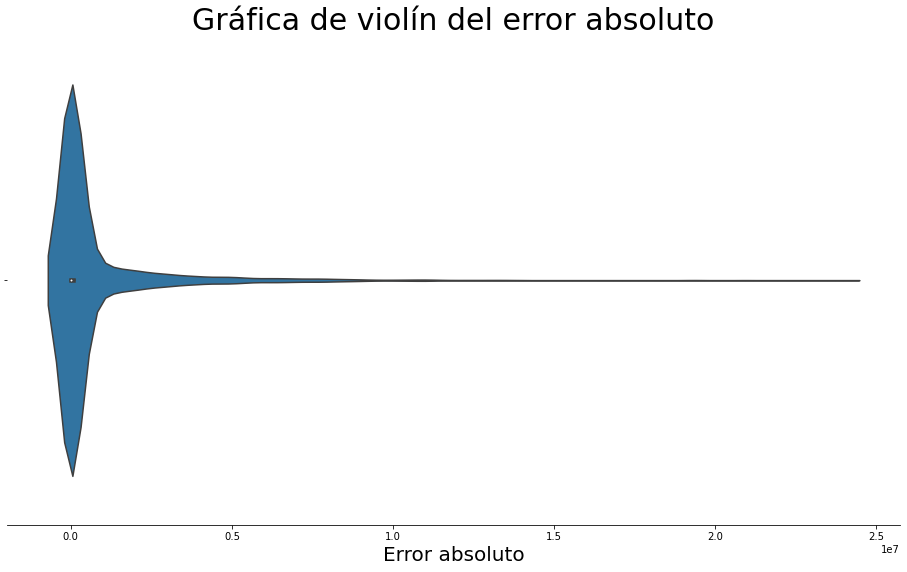

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
sns.violinplot(x="absolute_error", data=error_df, ax=ax)
ax.set_xlabel("Error absoluto", fontsize = 20)
ax.set_title("Gráfica de violín del error absoluto", fontsize = 30)
[ax.spines[i].set_visible(False) for i in ax.spines if i != "bottom"]; # To delete the spines
fig.savefig("../imgs/ViolinAbsoluto.png", bbox_inches="tight")

## Error cuadrático

In [23]:
rmse = np.sqrt(error_df.squared_error.mean())
td_rmse = timedelta(milliseconds=rmse*10)
print(f"RMSE:\t{rmse}[cs]")
print(f"\t{td_rmse} [DD, HH:MM:SS]")

RMSE:	2034299.5079779795[cs]
	5:39:02.995080 [DD, HH:MM:SS]


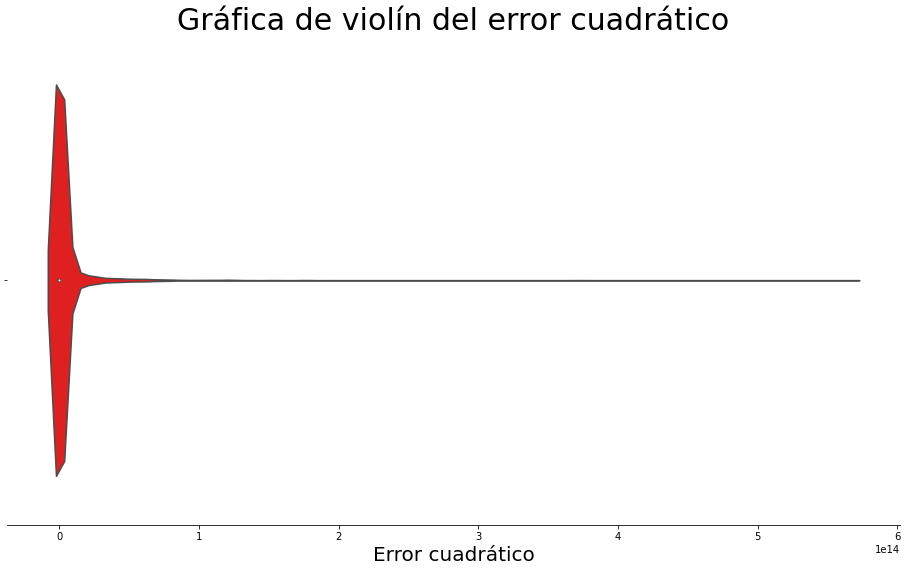

In [24]:
fig, ax = plt.subplots(figsize=(16,9))
sns.violinplot(x="squared_error", data=error_df, ax=ax, color = "red")
ax.set_xlabel("Error cuadrático", fontsize = 20)
ax.set_title("Gráfica de violín del error cuadrático", fontsize = 30)
[ax.spines[i].set_visible(False) for i in ax.spines if i != "bottom"]; # To delete the spines)
fig.savefig("../imgs/ViolinCuadratico.png", bbox_inches="tight")

## Tiempos de erupción

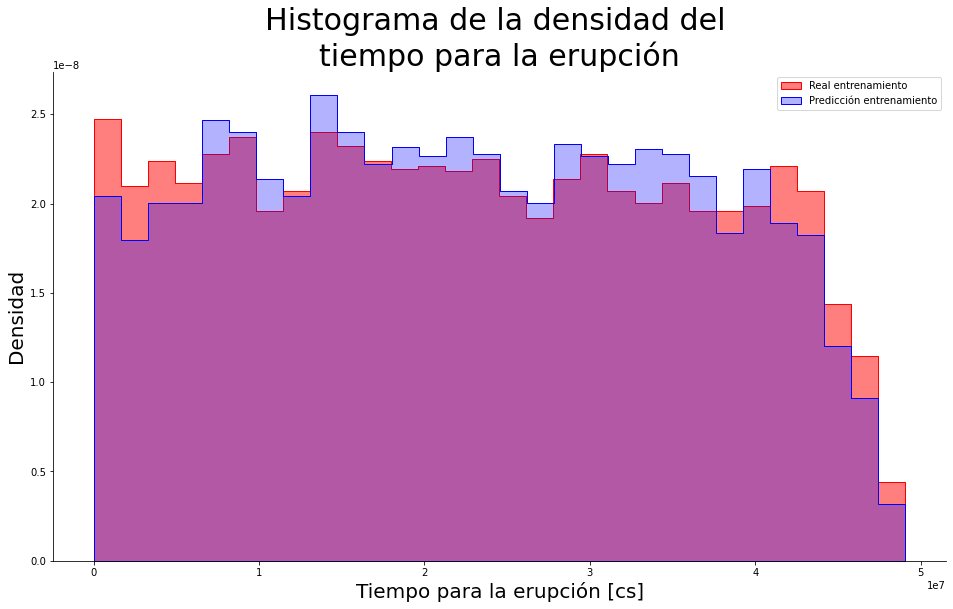

In [25]:
fig, ax = plt.subplots(ncols=1,figsize=(16,9))
sns.histplot(x="time_to_eruption", data=error_df, stat="density", bins=30,
             ax=ax, color="red", alpha=0.5, fill=True, element="step", legend=True)
sns.histplot(x="time_to_eruption_pred", data=error_df, stat="density", bins=30,
             ax=ax, color="blue", alpha=0.3,fill=True, element="step", legend=True)
ax.legend(["Real entrenamiento", "Predicción entrenamiento"])
ax.set_xlabel("Tiempo para la erupción [cs]", fontsize = 20)
ax.set_ylabel("Densidad", fontsize = 20)
ax.set_title("Histograma de la densidad del \ntiempo para la erupción", fontsize = 30)
[ax.spines[i].set_visible(False) for i in ax.spines if i not in ["bottom", "left"]]; # To delete the spines
fig.savefig("../imgs/Histograma1.png", bbox_inches="tight")

In [26]:
submission = pd.read_csv("../csvs/submission_estandarizados.csv")
submission

,segment_id,time_to_eruption
0,167894616,2.082773e+07
1,557603051,3.758432e+07
2,1264405485,3.319847e+07
3,1782053877,3.794619e+07
4,1464708932,3.114108e+07
...,...,...
4515,1697079567,2.537965e+07
4516,2016414965,3.779758e+07
4517,135642091,3.376477e+07
4518,1022920538,2.105625e+06


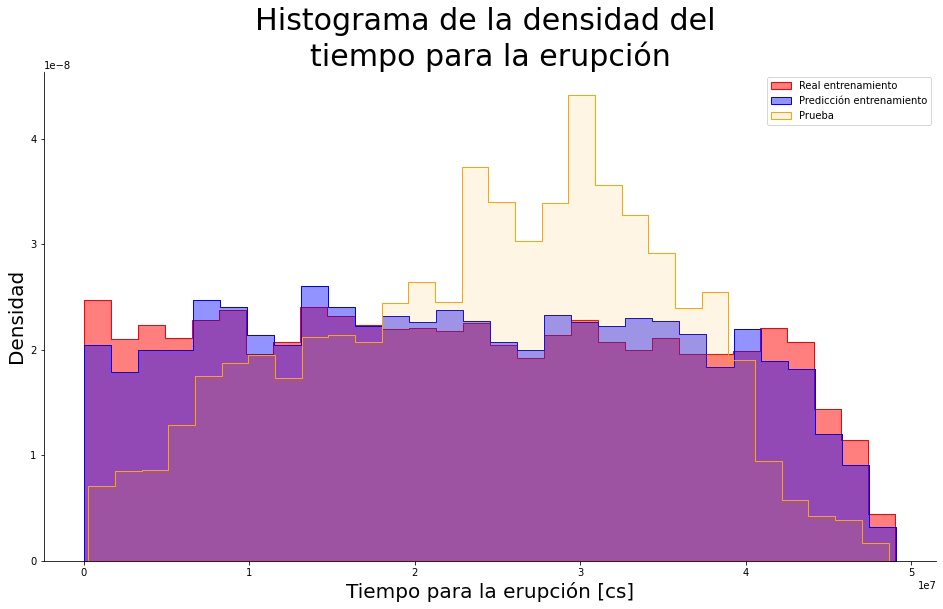

In [27]:
fig, ax = plt.subplots(ncols=1,figsize=(16,9))
sns.histplot(x="time_to_eruption", data=error_df, stat="density", bins=30,
             ax=ax, color="red", alpha=0.5, fill=True, element="step", legend=True)
sns.histplot(x="time_to_eruption_pred", data=error_df, stat="density", bins=30,
             ax=ax, color="blue", alpha=0.425,fill=True, element="step", legend=True)
sns.histplot(x="time_to_eruption", data=submission, stat="density", bins=30,
             ax=ax, color="orange", alpha=0.1, fill=True, element="step", legend=True)

ax.set_xlabel("Tiempo para la erupción [cs]", fontsize = 20)
ax.set_ylabel("Densidad", fontsize = 20)
ax.set_title("Histograma de la densidad del \ntiempo para la erupción", fontsize = 30)
ax.legend(["Real entrenamiento", "Predicción entrenamiento", "Prueba"])
[ax.spines[i].set_visible(False) for i in ax.spines if i not in ["bottom", "left"]]; # To delete the spines
fig.savefig("../imgs/Histograma2.png", bbox_inches="tight")

Lo principal que debemos notar del gráfico anterior, es que las distribuciones que tenemos para los conjuntos de entrenamiento y de prueba son muy diferentes. La de entrenamiento es casi uniforme exceptuando por la última parte mientras que la segunda presenta más la forma de campana pero sesgada negativamente, es decir, a la izquierda.

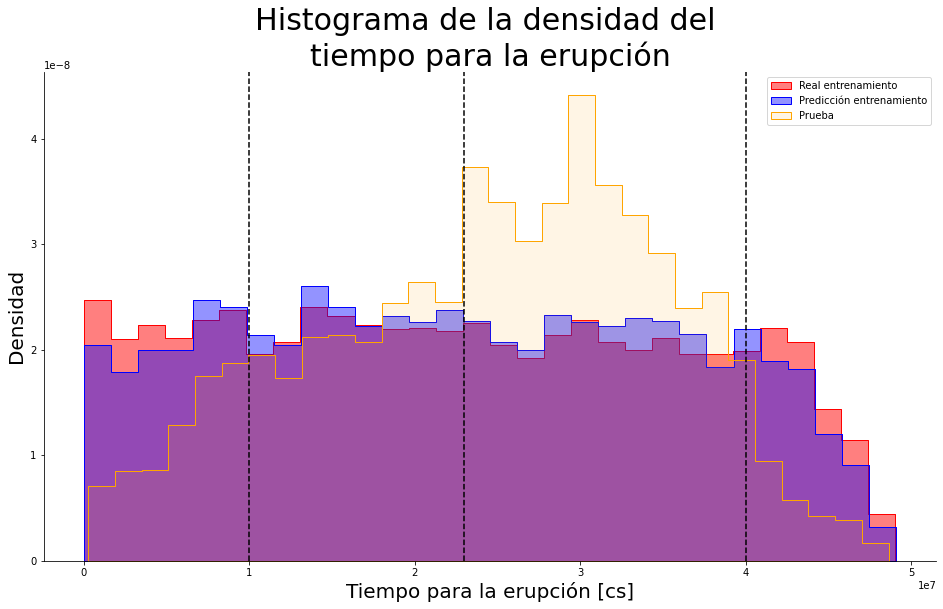

In [28]:
fig, ax = plt.subplots(ncols=1,figsize=(16,9))
sns.histplot(x="time_to_eruption", data=error_df, stat="density", bins=30,
             ax=ax, color="red", alpha=0.5, fill=True, element="step", legend=True)
sns.histplot(x="time_to_eruption_pred", data=error_df, stat="density", bins=30,
             ax=ax, color="blue", alpha=0.425,fill=True, element="step", legend=True)
sns.histplot(x="time_to_eruption", data=submission, stat="density", bins=30,
             ax=ax, color="orange", alpha=0.1, fill=True, element="step", legend=True)

ax.set_xlabel("Tiempo para la erupción [cs]", fontsize = 20)
ax.set_ylabel("Densidad", fontsize = 20)
ax.set_title("Histograma de la densidad del \ntiempo para la erupción", fontsize = 30)

ax.legend(["Real entrenamiento", "Predicción entrenamiento", "Prueba"])
ax.axvline(1e7,c="black", ls="--")
ax.axvline(2.3e7,c="black", ls="--")
ax.axvline(4e7,c="black", ls="--")
[ax.spines[i].set_visible(False) for i in ax.spines if i not in ["bottom", "left"]]; # To delete the spines
fig.savefig("../imgs/Histograma3.png", bbox_inches="tight")

Esto significa que el modelo es más confiable con predicciones entre 100,000 y 230,000 segundos (1 y 2.3 en la gráfica), lo cual se traduce entre 27 y 64 horas, aproximadamente.

Por otro lado, predicciones antes de 100,000 segundos y después de 2.3 ya no son tan confiables. En el caso de los tiempos anteriores a 100,000 segundos, dado que hay menos de los que debería, se debe entender que es probable que la erupción ocurra **más tarde**. Por otro lado, tiempos de erupción que se obtienen de 230,000 y 400,000 segundos, dado que hay más de los que debería, se entiende que es probable que la erupción ocurra **más temprano**.

[Regresar al índice](#Índice)